In [7]:
# # BCM Rule - recurrent network
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
get_ipython().magic('matplotlib inline')

In [417]:
class NeuralNet(object):
    
    def __init__(self, GROUPS_NUM=5, FF_NUM=200, REC_EXC_NUM=100, REC_INH_NUM=100, 
                 TOT_TIME=20, STEPS_DIM=0.0001,  TIME_CONST = 0.01,
                 TARGET_RATE=20, STARTING_RATE = 20, MEAN_DRIVE = 10,
                 THETA_START=0.07, ETA_E=float('1e-6'), ETA_I=float('1e-4'), TAU=1,
                 FF_PL=False, REC_PL_E=False, REC_PL_I=False):
        
        self.GROUPS_NUM = GROUPS_NUM
            
        self.FF_NUM = FF_NUM
        self.REC_EXC_NUM = REC_EXC_NUM
        self.REC_INH_NUM = REC_INH_NUM
        self.REC_NUM = REC_EXC_NUM + REC_INH_NUM        
        self.TOT_TIME = TOT_TIME
        self.STEPS_DIM = STEPS_DIM
        self.STARTING_RATE = STARTING_RATE #starting rate for recurrent network
        self.TARGET_RATE = TARGET_RATE
        self.THETA_START = THETA_START
        self.ETA_E = ETA_E
        self.ETA_I = ETA_I
        self.TAU = TAU #for weights
        self.FF_PL = FF_PL
        self.REC_PL_E = REC_PL_E
        self.REC_PL_I = REC_PL_I
        self.TIME_CONST = TIME_CONST #for rate
        self.MEAN_DRIVE = MEAN_DRIVE
        

        
        self.change_values()
        self.set_ff_activation()
        
        
    def __repr__(self):
        return '''%d FF neurons\n%d REC neurons''' % (self.FF_NUM, self.REC_NUM) 
        
        
    def change_values(self):
        
        self.STEPS_N = round(self.TOT_TIME/self.STEPS_DIM) # time steps = total simulation time / simulation step size
        self.time_vect = np.linspace(0,self.TOT_TIME, self.STEPS_N) # create a time vector of size TOT.time and step size 
        
        self.rec_nn = np.zeros((self.REC_NUM, self.STEPS_N)) # create empty array with size of the recurrent network
        self.rec_nn[:,0] = np.random.randint(0,self.STARTING_RATE,self.REC_NUM) # intial firing rates at time step 0
        
        self.ff_nn = np.zeros((self.REC_NUM, self.STEPS_N))
        
        # create a random weight matrix for feed-forward input (size REC x FF) 
        self.w_ff = np.eye(self.REC_NUM)
        
        # create a random weight matrix for the recurrent network
        
        #Draw recurrent weights from gamma distribution
        R = 0.1 #Limit radius for eigenvalues in complex space
        K = 2 #shape of the Gamma distribution
        THETA = R/((2*self.REC_NUM)**(1/2.0))

        w_rec = np.random.gamma(K, THETA, [self.REC_NUM,self.REC_NUM])
        np.fill_diagonal(w_rec,0)
        scal = np.absolute(sum(w_rec[:,:self.REC_EXC_NUM].T)/sum(w_rec[:,self.REC_EXC_NUM:].T))
        w_rec[:,self.REC_EXC_NUM:] = w_rec[:,self.REC_EXC_NUM:] * scal.reshape((-1,1))
        w_rec[:,self.REC_EXC_NUM:] = -w_rec[:,self.REC_EXC_NUM:]
        
        self.w_rec = w_rec
        
        self.theta = np.zeros((self.REC_NUM, self.STEPS_N))
        self.theta[:,0] = self.THETA_START
        
        self.w_sample = np.zeros((10, self.STEPS_N))
        self.w_history = np.zeros((self.REC_NUM, self.REC_NUM, 2))
    
    
    def set_ff_activation(self, BACKGROUND_TYPE='none', BACKGROUND_VALUE=None, 
                          STIM_TYPE='none', STIM_VALUE=None, STIM_LENGTH=None, #STIM_END=None,
                        target_neurons=None):
                        #target_neurons=[]):
        
        if STIM_VALUE is None:
            STIM_VALUE = self.STARTING_RATE/4
        if BACKGROUND_VALUE is None:
            NOISE_VALUE = STIM_VALUE/4
        if STIM_LENGTH is None:
            STIM_LENGTH = round(self.TOT_TIME/2)
        if target_neurons is None:
            target_neurons = list(range(round(self.REC_NUM/5)))
            
        
        #Set the background (input values to nonstimulated neurons - zero or random noise)
        if BACKGROUND_TYPE=='none':
            #Set the input values of the non stimulated neurons
            noise = np.zeros((self.REC_NUM, self.STEPS_N)) 
            
        elif BACKGROUND_TYPE=='random':
            #Set the input values of the non stimulated neurons
            noise = np.random.rand(
                self.REC_NUM, self.time_vect.shape[0])*NOISE_VALUE 
            
        elif BACKGROUND_TYPE=='OU_noise':
            noise = correlated_ou_process(self, N = self.FF_NUM, VAR=STIM_VALUE)
        
        signal = np.zeros((len(target_neurons), self.STEPS_N)) 

        if STIM_TYPE=='OU_noise':
            signal = correlated_ou_process(self, N = len(target_neurons), VAR=NOISE_VALUE)
        
        self.ff_nn = noise
        #self.ff_nn[target_neurons,:] = signal
        

        
    def display_stim(self):
        f, ax = plt.subplots(1,1, figsize = (20,5))
        ax.imshow(self.ff_nn, aspect='auto',  interpolation='nearest')
        plt.colorbar
        
        
    
    def run_network(self):
        
        #  rec.nn                           --> recurrent network 
        #  STEPS_DIM/TIME_CONST             --> size of simulation interval / rate time constant
        #  self.rec_nn                     --> leaky term 
        #  w_rec dot rec_nn                --> matrix multiplication of recurrent weight matrix and recurrent 
        #  w_ff dot ff_nn                  --> feed-forward weight matrix * feed-forward input firing rates
        self.w_history[:,:,0] = self.w_rec
        
        for i in range(1,self.STEPS_N):
            self.rec_nn[:,i] = self.rec_nn[:,i-1] + (self.STEPS_DIM/self.TIME_CONST)*(
                    -self.rec_nn[:,i-1] + io_function(self.w_rec[:,:].dot(self.rec_nn[:,i-1]) + 
                    self.w_ff[:,:].dot(self.ff_nn[:,i-1]) + self.MEAN_DRIVE))
            
            # BCM threshold theta
            # TAU --> BCM time constant

            
            # recurrent network placticiy
            # ETA --> factor of the BCM rule

            if i%500 == 0 and i > (5*self.TAU/self.STEPS_DIM):
                if self.REC_PL_E:
                    self.w_rec[:,:self.REC_EXC_NUM] = self.w_rec[:,:self.REC_EXC_NUM] + self.ETA_E*np.outer(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])), 
                        (self.rec_nn[:self.REC_EXC_NUM,i-1]))
                    
                if self.REC_PL_I:
                    self.w_rec[:,self.REC_EXC_NUM:] = self.w_rec[:,self.REC_EXC_NUM:] - self.ETA_I*np.outer(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.TARGET_RATE)), 
                        (self.rec_nn[self.REC_EXC_NUM:,i-1]))
                    
                if self.FF_PL:                
                    self.w_ff = self.w_ff + self.ETA *(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])) * self.ff_nn[:,i-1].T)

                
                np.fill_diagonal(self.w_rec[:,:], 0) # set diagonal to 0 to prevent self-excitation

                #self.w_ff = self.w_ff.clip(0)

            self.w_rec[:,:self.REC_EXC_NUM] = np.clip(self.w_rec[:,:self.REC_EXC_NUM], 0, np.inf)
            self.w_rec[:,self.REC_EXC_NUM:] = np.clip(self.w_rec[:,self.REC_EXC_NUM:], -np.inf,0)
                
            self.theta[:,i] = self.theta[:,i-1] + (self.STEPS_DIM/self.TAU) * (
                -self.theta[:,i-1] + (self.rec_nn[:,i]**2)/self.TARGET_RATE)
            
            self.w_sample[:5,i] = self.w_rec[0,:5]
            self.w_sample[5:,i] = self.w_rec[0,-5:]
            
            self.w_history[:,:,1] = self.w_rec
            
                                
    def plot_rate(self):
        f, ax = plt.subplots(1,2, figsize = (20,5))

        img1 = ax[0].imshow(self.rec_nn[:,::1000], aspect='auto', interpolation = 'nearest')
        ax[0].set_title('change in network firing rate over time')
        plt.colorbar(img1, ax=ax[0])
        
        ax[1].plot(np.mean(self.rec_nn[:,:],0)) #mean rate over time over network 
        ax[1].set_title('mean change in rate of whole network over simulation')
    
    def plot_weight(self):
        f, ax = plt.subplots(1,2, figsize = (20,5))
        ax[0].set_title('change in weights of subset of exc and inh neurons over simulation')
        img1 = ax[0].pcolor(self.w_sample[:,::100], vmin=-4, vmax=4)
        plt.colorbar(img1, ax=ax[0])
        #plt.show()
        
        img2 = ax[1].imshow(self.w_history[:,:,0], interpolation='nearest')
        ax[1].set_title('weight matrix at beginning of the simulation')
        plt.colorbar(img2, ax=ax[1])

def correlated_ou_process(self, N, VAR=1, TAU=0.05):
    POS_CORR = 0 #positive correlation for inputs on covariance matrix
    NEG_CORR = 0 #negative correlation for inputs elsewhere 
    GROUP_SIZE = int(N/self.GROUPS_NUM) #number of neurons in each group 

    block = POS_CORR*np.ones([GROUP_SIZE, GROUP_SIZE])
    sigma_noise = np.kron(np.eye(self.GROUPS_NUM), block) #block diagonal 
    np.fill_diagonal(sigma_noise,VAR) #variances 
    sigma_noise[sigma_noise == 0] = NEG_CORR #fill everything else with -ve correlations 
    
    plt.imshow(sigma_noise, interpolation = 'nearest')
    plt.title('covariance matrix of input')
    plt.colorbar()
    plt.show()
    
    ell_noise = np.linalg.cholesky(sigma_noise)
    z_noise = np.sqrt(2*self.STEPS_DIM/TAU)

    noise = np.zeros((N,self.STEPS_N))
    noise[:,0] = ell_noise.dot(np.random.normal(0,1,(N)))
    
    for i in range(1,self.STEPS_N):
        noise[:,i] = (1 - self.STEPS_DIM/TAU)*noise[:,i-1] + z_noise*ell_noise.dot(np.random.normal(0,1,N))
    return noise


def io_function(x):
    #Nonlinear function that rectifies under 0 and 
    x[x<0] = 0
    x[x>=20] = 20+80*np.tanh((x[x>=20]-20)/80)

    return x

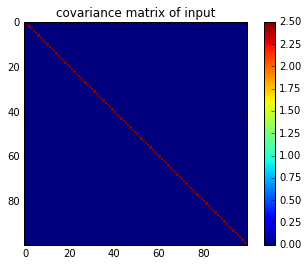

In [418]:
net = NeuralNet(GROUPS_NUM = 5, FF_NUM = 100, REC_EXC_NUM = 50, REC_INH_NUM = 50, TOT_TIME = 3,
                     STEPS_DIM = 0.001, TIME_CONST = 0.001, TARGET_RATE = 18, STARTING_RATE = 10, MEAN_DRIVE = 10,
                    THETA_START = 0.1, ETA_E = float('1e-7'), ETA_I = float('1e-6'), TAU = 1, FF_PL = False,
                    REC_PL_E = True, REC_PL_I = True) #TIME_CONST decay of rate, TAU is time constant of BCM
net.set_ff_activation(BACKGROUND_TYPE='OU_noise', BACKGROUND_VALUE = 1)

In [419]:
net.run_network()

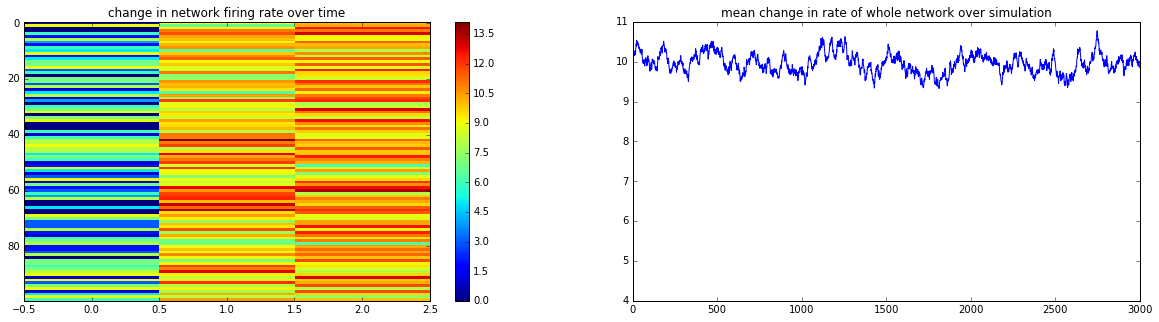

In [420]:
net.plot_rate()

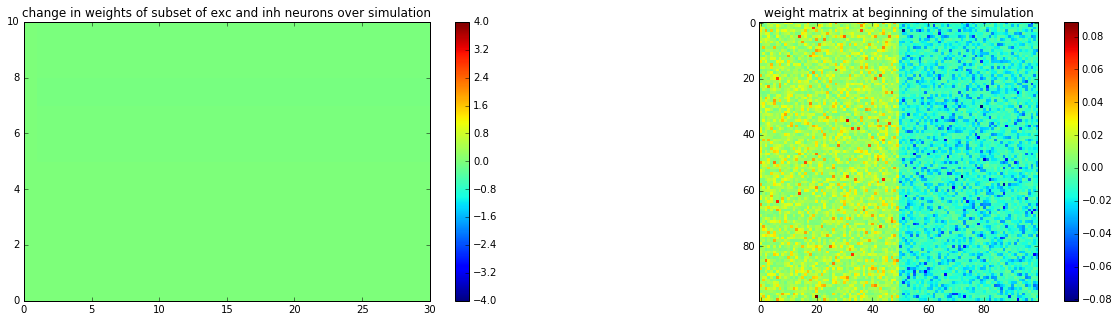

In [421]:
net.plot_weight()

Mean E: 0.014009 Mean I: -0.014009


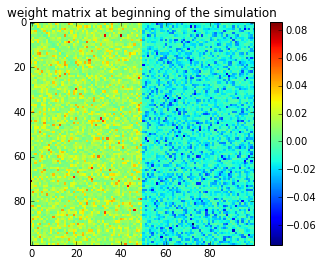

Mean E: 0.019422 Mean I: -0.010952


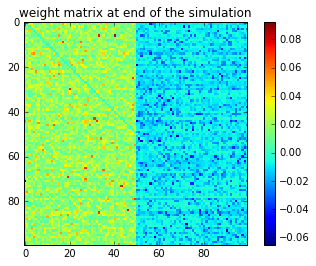

In [271]:
print('Mean E: %f Mean I: %f' %(np.mean(net.w_history[:,:net.REC_EXC_NUM,1]), np.mean(net.w_history[:,net.REC_EXC_NUM:,1]) ))
final_weights = net.w_history[:,:,1]
plt.imshow(final_weights, interpolation='nearest')
plt.title('weight matrix at end of the simulation')
plt.colorbar()
plt.show()

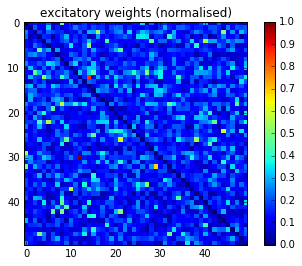

In [344]:
final_weights = net.w_history[:,:,1]
#exc_weights = final_weights[15:25,15:25]
exc_weights = final_weights[:net.REC_EXC_NUM,:net.REC_EXC_NUM]
exc_weights = np.divide(exc_weights, np.max(exc_weights))
plt.imshow(exc_weights, interpolation = 'nearest')
plt.colorbar()
plt.title('excitatory weights (normalised)')
plt.show()

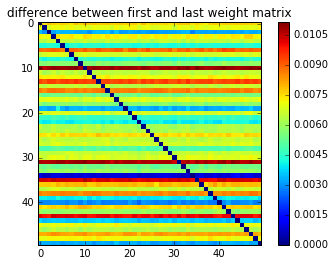

In [260]:
diff_weight = net.w_history[:,:,1]-net.w_history[:,:,0]
plt.imshow(diff_weight[:,:], interpolation='nearest')
plt.colorbar()
plt.title('difference between first and last weight matrix')
plt.show()

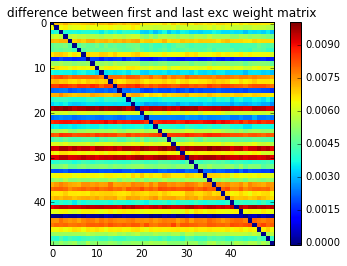

In [269]:
diff_exc_weight = net.w_history[:net.REC_EXC_NUM,:net.REC_EXC_NUM,1]-net.w_history[:net.REC_EXC_NUM,:net.REC_EXC_NUM,0]
plt.imshow(diff_exc_weight[:,:], interpolation='nearest')
plt.colorbar()
plt.title('difference between first and last exc weight matrix')
plt.show()

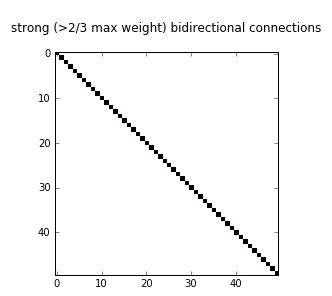

In [351]:
exc_diff = net.w_history[:,:,1]
exc_diff = final_weights[:net.REC_EXC_NUM,:net.REC_EXC_NUM]
exc_diff[exc_diff>int(2/3)] = 1
exc_diff[exc_diff<int(2/3)] = 0
overlap = (exc_diff == exc_diff.T) * exc_diff
bidirectional_connections = np.argwhere(exc_diff != 0)
plt.imshow(overlap, interpolation = 'nearest', cmap='hot')
plt.title('\n strong (>2/3 max weight) bidirectional connections \n')